# Examining machine learning approaches
# to detect sarcasm in Reddit comments

## Setup steps

Importing the Spark module and starting a Spark session:

In [1]:
# importing the findspark module
import findspark

# initializing Spark through the full path
findspark.init("/usr/local/spark/")

# importing the Sparksession module and functions, as well as the collections module
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import collections

# creating a Spark session and starting it
spark = SparkSession.builder \
   .master("local[8]") \
   .appName("SarcasmDetection") \
   .config("spark.executor.memory", "10gb") \
   .getOrCreate()

# creating the main entry point for Spark functionality
sc = spark.sparkContext

Loading the data from the CSV file as a Spark dataframe:

In [2]:
# loading the data as a dataframe while setting header to true to recognize the first line as the column names 
# and inferSchema to True to automatically detect the datatypes 
df_sarcasm = spark.read.csv("./train-balanced-sarcasm.csv", header=True, inferSchema=True)
df_sarcasm.show(5)

+-----+--------------------+---------+------------------+-----+---+-----+-------+-------------------+--------------------+
|label|             comment|   author|         subreddit|score|ups|downs|   date|        created_utc|      parent_comment|
+-----+--------------------+---------+------------------+-----+---+-----+-------+-------------------+--------------------+
|    0|          NC and NH.|Trumpbart|          politics|    2| -1|   -1|2016-10|2016-10-16 23:55:23|Yeah, I get that ...|
|    0|You do know west ...|Shbshb906|               nba|   -4| -1|   -1|2016-11|2016-11-01 00:24:10|The blazers and M...|
|    0|They were underdo...| Creepeth|               nfl|    3|  3|    0|2016-09|2016-09-22 21:45:37|They're favored t...|
|    0|"This meme isn't ...|icebrotha|BlackPeopleTwitter|   -8| -1|   -1|2016-10|2016-10-18 21:03:47|deadass don't kil...|
|    0|I could use one o...|cush2push|MaddenUltimateTeam|    6| -1|   -1|2016-12|2016-12-30 17:00:13|Yep can confirm I...|
+-----+---------

## Initial data analysis

Checking the datatypes of the variables:

In [3]:
# "df.printSchema()" displays all variables of the dataframe and their datatype
df_sarcasm.printSchema()

root
 |-- label: integer (nullable = true)
 |-- comment: string (nullable = true)
 |-- author: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- score: string (nullable = true)
 |-- ups: string (nullable = true)
 |-- downs: string (nullable = true)
 |-- date: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- parent_comment: string (nullable = true)



In [4]:
# using the describe-method to further investigate the two most important columns
df_sarcasm.describe(["label", "comment"]).show()

+-------+----------------+--------------------+
|summary|           label|             comment|
+-------+----------------+--------------------+
|  count|         1010826|             1010773|
|   mean|             0.5|            Infinity|
| stddev|0.50000024732267|                 NaN|
|    min|               0Still doesn't he...|
|    max|               1|~~~~ ALERT THE CO...|
+-------+----------------+--------------------+



There seem to be some rows that have no value in the comment-column, indicated by the difference in count. We will handle this issue later in the preprocessing by dropping these rows. 

Finding out the number of subreddits in the file:

In [5]:
# using select to only select the "subreddit"-column, distinct to only get the unique values 
# and count to get their count as an integer
subreddits = df_sarcasm.select(["subreddit"]).distinct().count()
print(f"Number of distinct subreddits: {subreddits}")

Number of distinct subreddits: 23669


Checking the dataset's size:

In [6]:
# getting the number of rows of the dataframe with the "df.count()"-method
print(f"Number of rows: {df_sarcasm.count()}")

Number of rows: 1010826


Creating a balanced excerpt of the dataset:

In [7]:
# filtering the dataframe with a set limit, to decrease its size 
# while maintaing a 50:50 distribution of the labels
filtered_df0 = df_sarcasm.filter(df_sarcasm["label"] == 0).limit(30000)
filtered_df1 = df_sarcasm.filter(df_sarcasm["label"] == 1).limit(30000)
# unifying the two dataframes into one
df_sarcasm = filtered_df0.union(filtered_df1)
df_sarcasm.show(5)

+-----+--------------------+---------+------------------+-----+---+-----+-------+-------------------+--------------------+
|label|             comment|   author|         subreddit|score|ups|downs|   date|        created_utc|      parent_comment|
+-----+--------------------+---------+------------------+-----+---+-----+-------+-------------------+--------------------+
|    0|          NC and NH.|Trumpbart|          politics|    2| -1|   -1|2016-10|2016-10-16 23:55:23|Yeah, I get that ...|
|    0|You do know west ...|Shbshb906|               nba|   -4| -1|   -1|2016-11|2016-11-01 00:24:10|The blazers and M...|
|    0|They were underdo...| Creepeth|               nfl|    3|  3|    0|2016-09|2016-09-22 21:45:37|They're favored t...|
|    0|"This meme isn't ...|icebrotha|BlackPeopleTwitter|   -8| -1|   -1|2016-10|2016-10-18 21:03:47|deadass don't kil...|
|    0|I could use one o...|cush2push|MaddenUltimateTeam|    6| -1|   -1|2016-12|2016-12-30 17:00:13|Yep can confirm I...|
+-----+---------

Checking the distribution of the data:

In [8]:
# checking if the distribution of the data is 50:50 by filtering and counting the rows per label
print(df_sarcasm.filter(df_sarcasm.label == 0).count())
print(df_sarcasm.filter(df_sarcasm.label == 1).count())

30000
30000


Creating a new dataframe with only the desired columns for further work:

In [9]:
# using "df.select" to only select the "label"- and "comment"-columns
df_sarcasm2 = df_sarcasm.select("label", "comment")
df_sarcasm2.show(5)

+-----+--------------------+
|label|             comment|
+-----+--------------------+
|    0|          NC and NH.|
|    0|You do know west ...|
|    0|They were underdo...|
|    0|"This meme isn't ...|
|    0|I could use one o...|
+-----+--------------------+
only showing top 5 rows



##  Data Preprocessing

Importing the packages for preprocessing and model creation:

In [10]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import CountVectorizer

from pyspark.sql.functions import regexp_replace, col
from pyspark.ml.feature import Tokenizer, NGram
from pyspark.sql import functions as F
from pyspark.ml.feature import StopWordsRemover, HashingTF, IDF

Removing special characters, numbers and quotations from the comments and dropping rows that miss values:

In [11]:
# using the "df.withColumn"-method to create a function that handles numbers and special characters 
def preprocessing(df):
    # removes special characters, numbers and quotation marks from a dataframe
    df = df.withColumn("comment", F.regexp_replace(col("comment"), "[_():;,.!?\\-]", ""))
    df = df.withColumn("comment", F.regexp_replace(col("comment"), "[0-9]", ""))
    df = df.withColumn("comment", F.regexp_replace(col("comment"), '"', ""))
    # by specifying "how=any" all rows where one of the values in a column is null are dropped
    df = df.dropna(how="any")
    return df

# applying the function to the dataframe
pre = preprocessing(df_sarcasm2)
pre.show(5)

+-----+--------------------+
|label|             comment|
+-----+--------------------+
|    0|           NC and NH|
|    0|You do know west ...|
|    0|They were underdo...|
|    0|This meme isn't f...|
|    0|I could use one o...|
+-----+--------------------+
only showing top 5 rows



Checking how many rows were dropped:

In [12]:
# checking how many rows were dropped by counting the rows in the preprocessed dataframe
print(f"Number of rows after initial preprocessing: {pre.count()}")

Number of rows after initial preprocessing: 59998


After the initial preprocessing steps, we removed special characters and dropped a few rows of the dataframe which contained empty values. 

Tokenizing means turning the text into an array of words for further processing.

In [13]:
# tokenizing the text-column (splitting the comments into arrays of words)
tokenizer = Tokenizer(inputCol="comment", outputCol="words")
tokenized = tokenizer.transform(pre)
tokenized.show(5)

+-----+--------------------+--------------------+
|label|             comment|               words|
+-----+--------------------+--------------------+
|    0|           NC and NH|       [nc, and, nh]|
|    0|You do know west ...|[you, do, know, w...|
|    0|They were underdo...|[they, were, unde...|
|    0|This meme isn't f...|[this, meme, isn'...|
|    0|I could use one o...|[i, could, use, o...|
+-----+--------------------+--------------------+
only showing top 5 rows



Stemming or lemmatization  simplifies tokens to their root forms, enhancing uniformity and the efficacy of subsequent stop word filtering by ensuring consistent treatment of word variations.

In [14]:
# Install the NLTK library using pip, a package installer for Python
!pip install nltk

# Importing necessary functions and types from pyspark.sql module for working with Spark DataFrames
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

# Importing WordNetLemmatizer from NLTK for lemmatization
from nltk.stem import WordNetLemmatizer

# Initialize the WordNetLemmatizer to be used for converting words to their base or lemma form
lemmatizer = WordNetLemmatizer()

# Define a UDF for lemmatizing an array of words
def lemmatize_words(words):
    return [lemmatizer.lemmatize(word) for word in words]

lemmatize_udf = udf(lemmatize_words, ArrayType(StringType()))

# Apply the UDF to the tokenized words
lemmatized = tokenized.withColumn("lemmatizedWords", lemmatize_udf("words"))

lemmatized.show(5)

+-----+--------------------+--------------------+--------------------+
|label|             comment|               words|     lemmatizedWords|
+-----+--------------------+--------------------+--------------------+
|    0|           NC and NH|       [nc, and, nh]|       [nc, and, nh]|
|    0|You do know west ...|[you, do, know, w...|[you, do, know, w...|
|    0|They were underdo...|[they, were, unde...|[they, were, unde...|
|    0|This meme isn't f...|[this, meme, isn'...|[this, meme, isn'...|
|    0|I could use one o...|[i, could, use, o...|[i, could, use, o...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



Handling abbreviations and slang like "lol", especially important after lemmatization

In [15]:
# Create a dictionary for common abbreviations and slang terms
abbr_slang_dict = {
    "lol": "laughing out loud",
    "brb": "be right back",
    "gtg": "got to go",
    "idk": "I don't know",
    "imo": "in my opinion",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "fyi": "for your information"
}

# Implement a function to expand abbreviations and slang in text
def expand_abbr_slang(text_list):
    expanded_text = []
    for word in text_list:
        if word.lower() in abbr_slang_dict:
            expanded_text.append(abbr_slang_dict[word.lower()])
        else:
            expanded_text.append(word)
    return expanded_text

# Convert the function to a UDF
expand_abbr_slang_udf = udf(expand_abbr_slang, ArrayType(StringType()))

# Apply the UDF to the DataFrame column containing lemmatized words
expanded_lemmatized = lemmatized.withColumn("expandedLemmatizedWords", expand_abbr_slang_udf("lemmatizedWords"))

# Show the results
expanded_lemmatized.select("expandedLemmatizedWords").show(5)

+-----------------------+
|expandedLemmatizedWords|
+-----------------------+
|          [nc, and, nh]|
|   [you, do, know, w...|
|   [they, were, unde...|
|   [this, meme, isn'...|
|   [i, could, use, o...|
+-----------------------+
only showing top 5 rows



Remove common stop words (frequently occurring words that are usually ignored in text processing) from the lemmatized text, transforming the original "words" column into a new "terms" column with stop words removed, enhancing the focus on more meaningful words for analysis.

In [16]:
# creating a StopWordsRemover object
stopwordsremover = StopWordsRemover(inputCol="words", outputCol="terms")
# using it on the current dataframe
wo_stop = stopwordsremover.transform(expanded_lemmatized)
wo_stop.show(5)

+-----+--------------------+--------------------+--------------------+-----------------------+--------------------+
|label|             comment|               words|     lemmatizedWords|expandedLemmatizedWords|               terms|
+-----+--------------------+--------------------+--------------------+-----------------------+--------------------+
|    0|           NC and NH|       [nc, and, nh]|       [nc, and, nh]|          [nc, and, nh]|            [nc, nh]|
|    0|You do know west ...|[you, do, know, w...|[you, do, know, w...|   [you, do, know, w...|[know, west, team...|
|    0|They were underdo...|[they, were, unde...|[they, were, unde...|   [they, were, unde...|[underdogs, earli...|
|    0|This meme isn't f...|[this, meme, isn'...|[this, meme, isn'...|   [this, meme, isn'...|[meme, funny, non...|
|    0|I could use one o...|[i, could, use, o...|[i, could, use, o...|   [i, could, use, o...|   [use, one, tools]|
+-----+--------------------+--------------------+--------------------+--

This step generates bigrams (pairs of adjacent words) from the tokenized text in the "words" column of the DataFrame wo_stop, creating a new column "ngrams" that contains these bigrams, which can capture more contextual information and relationships between words for further analysis

In [17]:
# Assuming 'tokenized' is your DataFrame with a column named "words" that contains the tokenized text
ngram = NGram(n=2, inputCol="words", outputCol="ngrams")
ngram_df = ngram.transform(wo_stop)

ngram_df.show(5)

+-----+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+
|label|             comment|               words|     lemmatizedWords|expandedLemmatizedWords|               terms|              ngrams|
+-----+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+
|    0|           NC and NH|       [nc, and, nh]|       [nc, and, nh]|          [nc, and, nh]|            [nc, nh]|    [nc and, and nh]|
|    0|You do know west ...|[you, do, know, w...|[you, do, know, w...|   [you, do, know, w...|[know, west, team...|[you do, do know,...|
|    0|They were underdo...|[they, were, unde...|[they, were, unde...|   [they, were, unde...|[underdogs, earli...|[they were, were ...|
|    0|This meme isn't f...|[this, meme, isn'...|[this, meme, isn'...|   [this, meme, isn'...|[meme, funny, non...|[this meme, meme ...|
|    0|I could use one o...|[i, could, us

This step applies the CountVectorizer to convert the n-grams generated in the previous step into feature vectors, effectively creating a sparse matrix representation where each column corresponds to a specific n-gram and each cell contains the count of occurrences of that n-gram in a document. The transformation results in a new column "features" in the DataFrame cv_df, which holds these vectorized features, making the data suitable for input into machine learning models.

In [18]:
# Instantiate CountVectorizer to transform n-grams into feature vectors
cv = CountVectorizer(inputCol="ngrams", outputCol="features")

# Fit the model and transform the data
cv_model = cv.fit(ngram_df)
cv_df = cv_model.transform(ngram_df)

cv_df.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|(250303,[26577,74...|
|(250303,[161,400,...|
|(250303,[132,4630...|
|(250303,[1,236,10...|
|(250303,[70,276,3...|
+--------------------+
only showing top 5 rows



This step transforms the text in the "terms" column of the cv_df DataFrame into fixed-size numerical feature vectors using "HashingTF", assigning each word a hash index with frequency counts in vectors stored in a new "hash" column of the hashed DataFrame, thus efficiently preparing the text data for machine learning models with each vector containing 1024 features.

In [19]:
# perform feature hashing for term frequency
hashingTF = HashingTF(inputCol="terms", outputCol="hash", numFeatures=1024)
hashed = hashingTF.transform(cv_df)
hashed.show(5)

+-----+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+
|label|             comment|               words|     lemmatizedWords|expandedLemmatizedWords|               terms|              ngrams|            features|                hash|
+-----+--------------------+--------------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+
|    0|           NC and NH|       [nc, and, nh]|       [nc, and, nh]|          [nc, and, nh]|            [nc, nh]|    [nc and, and nh]|(250303,[26577,74...|(1024,[232,499],[...|
|    0|You do know west ...|[you, do, know, w...|[you, do, know, w...|   [you, do, know, w...|[know, west, team...|[you do, do know,...|(250303,[161,400,...|(1024,[48,77,477,...|
|    0|They were underdo...|[they, were, unde...|[they, were, unde...|   [they, were, unde...|[underdogs,

This process converts n-grams in cv_df to term frequency vectors using "HashingTF", then applies "IDF" to produce TF-IDF vectors in tfidf_df, creating a refined numerical representation of text for machine learning.

In [20]:
# convert n-grams into term frequency vectors
hashingTF = HashingTF(inputCol="ngrams", outputCol="rawFeatures", numFeatures=1024)
featurizedData = hashingTF.transform(cv_df)

# Compute the IDF model and transform the data with a new output column name
idf = IDF(inputCol="rawFeatures", outputCol="idfFeatures")  # Change output column name
idfModel = idf.fit(featurizedData)
tfidf_df = idfModel.transform(featurizedData)

tfidf_df.select("idfFeatures").show(5)

+--------------------+
|         idfFeatures|
+--------------------+
|(1024,[436,563],[...|
|(1024,[30,204,387...|
|(1024,[143,165,18...|
|(1024,[127,276,60...|
|(1024,[17,197,276...|
+--------------------+
only showing top 5 rows



In [21]:
idf = IDF(inputCol="rawFeatures", outputCol="newIdfFeatures") 
idfModel = idf.fit(featurizedData)  
tfidf_df = idfModel.transform(featurizedData)
tfidf_df.select("newIdfFeatures").show(5)

+--------------------+
|      newIdfFeatures|
+--------------------+
|(1024,[436,563],[...|
|(1024,[30,204,387...|
|(1024,[143,165,18...|
|(1024,[127,276,60...|
|(1024,[17,197,276...|
+--------------------+
only showing top 5 rows



Splitting the final dataframe into training and testing data:

In [22]:
# using randomSplit to split the data in a 80:20 proportion, setting a seed to ensure reproducibility
sarcasm_train, sarcasm_test = tfidf_df.randomSplit([0.8,0.2], seed=123)

## Model creation 

### Logistic regression model

In [23]:
# trying logistic regression, which is best suited for binary classification, on the preprocessed data
lr = LogisticRegression()
lr_model = lr.fit(sarcasm_train)
lr_prediction = lr_model.transform(sarcasm_test)
lr_prediction.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0| 2411|
|    0|       0.0| 3638|
|    1|       1.0| 3530|
|    0|       1.0| 2439|
+-----+----------+-----+



#### Performance evaluation

In [24]:
# computing the accuracy of the logistic regression model
# Count total number of predictions
total_predictions = lr_prediction.count()
# Count correct predictions
correct_predictions = lr_prediction.filter(col("prediction") == col("label")).count()
# Calculate accuracy
lr_acc = correct_predictions / total_predictions
print(f"Accuracy of the Logistic Regression Model: {lr_acc}")

Accuracy of the Logistic Regression Model: 0.5964386753203528


In [25]:
# getting the recall of the model
# Count true positives
tp = lr_prediction.filter((col("prediction") == col("label")) & (col("label") == 1)).count()
# Count false negatives
fn = lr_prediction.filter((col("prediction") != col("label")) & (col("label") == 0)).count()
# Calculate recall
lr_re = tp / (tp + fn)
print(f"Recall of the Logistic Regression Model: {lr_re}")

Recall of the Logistic Regression Model: 0.5913888423521528


In [26]:
# getting the precision of the model
# Count true positives
tp = lr_prediction.filter((col('prediction') == col('label')) & (col('label') == 1)).count()
# Count false positives
fp = lr_prediction.filter((col('prediction') != col('label')) & (col('label') == 1)).count()
# Calculate precision
lr_pre = tp / (tp + fp)
print(f"Precision of Logistic Regression Model: {lr_pre}")

Precision of Logistic Regression Model: 0.5941760646355833


### Naive Bayes Model

We will use a multinomial naive bayes model, as it is intended for natural language processing 

In [27]:
# creating an instance of a naive bayes model of multinomial type
nb = NaiveBayes(modelType="multinomial")
# fitting the model to training data and letting it predict the label of the test data
nb_model = nb.fit(sarcasm_train)
nb_prediction = nb_model.transform(sarcasm_test)
nb_prediction.select("label", "prediction").show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
+-----+----------+
only showing top 5 rows



#### Performance evaluation

In [28]:
#evaluating the naive bayes classifier with accuracy
# Count total number of predictions
total_predictions = nb_prediction.count()
# Count correct predictions
correct_predictions = nb_prediction.filter(col("prediction") == col("label")).count()
# Calculate accuracy
nb_acc = correct_predictions / total_predictions
print(f"Accuracy of the Naive Bayes Model: {nb_acc}")

Accuracy of the Naive Bayes Model: 0.6161590946912964


In [29]:
# getting the recall of the model
# Count true positives
tp = nb_prediction.filter((col("prediction") == col("label")) & (col("label") == 1)).count()
# Count false negatives
fn = nb_prediction.filter((col("prediction") != col("label")) & (col("label") == 0)).count()
# Calculate recall
nb_re = tp / (tp + fn)
print(f"Recall of the Naive Bayes Model: {nb_re}")

Recall of the Naive Bayes Model: 0.5915104740904079


In [30]:
# getting the precision of the model
# Count true positives
tp = nb_prediction.filter((col('prediction') == col('label')) & (col('label') == 1)).count()

# Count false positives
fp = nb_prediction.filter((col('prediction') != col('label')) & (col('label') == 1)).count()

# Calculate precision
nb_pre = tp / (tp + fp)
print(f"Precision of Naive Bayes Model: {nb_pre}")

Precision of Naive Bayes Model: 0.7224373001178253


### Decision Tree Model

In [31]:
# creating an instance of the decision tree classifier
dt = DecisionTreeClassifier()
# training the model on the training data and testing its performance with the remaining data
dt_model = dt.fit(sarcasm_train)
dt_prediction = dt_model.transform(sarcasm_test)
dt_prediction.select("label", "prediction").show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 5 rows



#### Performance evaluation

In [32]:
# getting the accuracy of the model
# Count total number of predictions
total_predictions = dt_prediction.count()
# Count correct predictions
correct_predictions = dt_prediction.filter(col("prediction") == col("label")).count()
# Calculate accuracy
dt_acc = correct_predictions / total_predictions
print(f"Accuracy of the Decision Tree Model: {dt_acc}")

Accuracy of the Decision Tree Model: 0.5224663005491762


In [33]:
# getting the recall of the model
# Count true positives
tp = dt_prediction.filter((col("prediction") == col("label")) & (col("label") == 1)).count()
# Count false negatives
fn = dt_prediction.filter((col("prediction") != col("label")) & (col("label") == 0)).count()
# Calculate recall
dt_re = tp / (tp + fn)
print(f"Recall of the Decision Tree Model: {dt_re}")

Recall of the Decision Tree Model: 0.9243697478991597


In [34]:
# getting the precision of the model
# Count true positives
tp = dt_prediction.filter((col('prediction') == col('label')) & (col('label') == 1)).count()
# Count false positives
fp = dt_prediction.filter((col('prediction') != col('label')) & (col('label') == 1)).count()
# Calculate precision
dt_pre = tp / (tp + fp)
print(f"Precision of Decision Tree Model: {dt_pre}")

Precision of Decision Tree Model: 0.0370308028951355


### Random Forest Model

In [35]:
# creating an instance of the random forest classifier
forest = RandomForestClassifier()
# training the model with the training data and then testing it
forest_model = forest.fit(sarcasm_train)
forest_prediction = forest_model.transform(sarcasm_test)
forest_prediction.select("label", "prediction").show(5)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
|    0|       1.0|
+-----+----------+
only showing top 5 rows



#### Performance evaluation

In [36]:
# getting the accuracy of the model
# Count total number of predictions
total_predictions = forest_prediction.count()
# Count correct predictions
correct_predictions = forest_prediction.filter(col("prediction") == col("label")).count()
# Calculate accuracy
forest_acc = correct_predictions / total_predictions
print(f"Accuracy of the Random Forest Model: {forest_acc}")

Accuracy of the Random Forest Model: 0.509069728740223


In [37]:
# getting the recall of the model
# Count true positives
tp = forest_prediction.filter((col("prediction") == col("label")) & (col("label") == 1)).count()
# Count false negatives
fn = forest_prediction.filter((col("prediction") != col("label")) & (col("label") == 0)).count()
# Calculate recall
forest_re = tp / (tp + fn)
print(f"Recall of the Random Forest Model: {forest_re}")

Recall of the Random Forest Model: 0.5017805958481716


In [38]:
# getting the precision of the model
# Count true positives
tp = forest_prediction.filter((col('prediction') == col('label')) & (col('label') == 1)).count()
# Count false positives
fp = forest_prediction.filter((col('prediction') != col('label')) & (col('label') == 1)).count()
# Calculate precision
forest_pre = tp / (tp + fp)
print(f"Precision of Random Forest Model: {forest_pre}")

Precision of Random Forest Model: 0.9723952196599899


## Visualization

#### Importing packages

In [39]:
# importing the necessary packages for the plot
import numpy as np
import matplotlib.pyplot as plt 

## Plotting the accuracy results

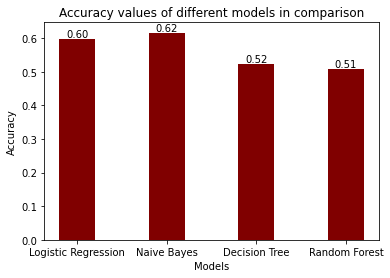

In [40]:
# defining the names of the models and the corresponding accuracy values as lists
models = ["Logistic Regression", "Naive Bayes", "Decision Tree", "Random Forest"]
values = [lr_acc, nb_acc, dt_acc, forest_acc]

# creating a bar plot that takes the two lists as input 
bars = plt.bar(models, values, color ="maroon", width = 0.4)

# adding the rounded values on top of the bars in the plot
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() /  2, height, "{:.2f}".format(height), ha="center", va="bottom")

# labelling the plot's axes and giving it a title
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Accuracy values of different models in comparison")

# displaying the final plot
plt.show()

Accuracy is the most general of the three measurements which we computed. It gives the percentage of the made predictions by the model that are correct, or, in other words, the probability of a random prediction by the model being correct. It is one of the best indicators for model performance.  

## Plotting the recall results

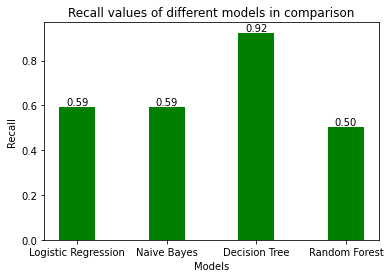

In [41]:
# defining the names of the models and the corresponding recall values as lists
models = ["Logistic Regression", "Naive Bayes", "Decision Tree", "Random Forest"]
values = [lr_re, nb_re, dt_re, forest_re]

# creating a bar plot that takes the two lists as input 
bars = plt.bar(models, values, color ="green", width = 0.4)

# adding the rounded values on top of the bars in the plot
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() /  2, height, "{:.2f}".format(height), ha="center", va="bottom")
    
# labelling the plot's axes and giving it a title
plt.xlabel("Models")
plt.ylabel("Recall")
plt.title("Recall values of different models in comparison")

# displaying the final plot
plt.show()

Recall is the number of true positives divided by the sum of true positives and false negatives. It is more relevant if false positives are more costly than false negatives. 

## Plotting the precision results

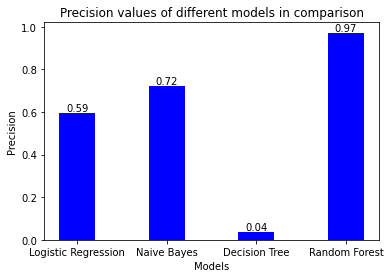

In [42]:
# defining the names of the models and the corresponding precision values as lists
models = ["Logistic Regression", "Naive Bayes", "Decision Tree", "Random Forest"]
values = [lr_pre, nb_pre, dt_pre, forest_pre]

# creating a bar plot that takes the two lists as input 
bars = plt.bar(models, values, color ="blue", width = 0.4)

# adding the rounded values on top of the bars in the plot
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() /  2, height, "{:.2f}".format(height), ha="center", va="bottom")

# labelling the plot's axes and giving it a title
plt.xlabel("Models")
plt.ylabel("Precision")
plt.title("Precision values of different models in comparison")

# displaying the final plot
plt.show()

Precision is calculated by dividing the true positives by the total sum of positives. It gives the percentage of positive objects in the data that the model correctly predicted. Precision is most relevant when false positives are more costly than false negatives. 

## Conclusion

Based on the plots we think the Naive Bayes model performed best in trying to predict sarcasm because it has the highest accuracy value and the second highest value in both recall and precision. 

In [43]:
# closing the spark session after the program is executed, in order to close the external connection 
# and free up resources 

spark.stop()